In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [3]:
import matplotlib.backends.backend_pdf

In [3]:
# from dichotomous_mult_model_fns import *

In [52]:
location_ids = [163,214,179]

ages = [1,2,3,4,5] # [49,50,51,52]
sexes = [1,2]

index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [5]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [6]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [21]:
def lognormal_draws(mu, sigma, seed):
    """
    INPUT:
    - mean of distirbution
    - std dev of distribution
    - random seed
    -----
    @returns: 1000 draws from a lognormal distribution with requested params
    """
    np.random.seed(seed)
    return np.random.lognormal(mu, sigma, size=1000)

In [49]:
def format_rrs(rrs, location_ids):
    """
    INPUT:
    - an array of 1000 rrs, representing the rr distribution
    - a list of location_ids
    -----
    @ returns: a DataFrame
        - long by loc_id
        - wide by draws
        - same rr for each draw for each loc_id
    """
    draws = [f'draw_{i}' for i in range(1_000)]
    
    df = pd.DataFrame([rrs for i in location_ids], index = location_ids, columns = draws)
    df.index.name = 'location_id'
    
    return df

In [54]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
163    1.712028
214    1.712028
179    1.712028
dtype: float64

In [62]:
coverage_data_path ='/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/nigeria_ethiopia_india_coverage_data.csv'
data = pd.read_csv(coverage_data_path)
alpha = (data.loc[data.vehicle == vehicle]
         .loc[data.nutrient == nutrient]
         .loc[data.value_description == 'percent of population eating fortified vehicle'])
alpha_star = (data.loc[data.vehicle == vehicle]
              .loc[data.value_description == 'percent of population eating industrially produced vehicle'])

#this is a hack; there's a line of data in here that doesn't apply to folic acid so i'm deleting it
alpha_star = alpha_star[(alpha_star.sub_population!='under-5')]


In [65]:
def generate_coverage_parameter_draws(df):
    """This function is used to generate 1000 draws of nutrient/vehicle coverage parameters based on
    the mean value and confidence intervals. This function assumes a normal distribution of uncertainty
    within the confidence interval centered around the mean and is truncated at the bounds of 0 and 100%"""
    data_frame = df.copy()
    np.random.seed(11)
    for i in list(range(0,1000)):
        data_frame[f'draw_{i}'] = scipy.stats.truncnorm.rvs(data_frame.a,
                                                            data_frame.b,
                                                            data_frame.value_mean,
                                                            data_frame.value_std) / 100
    data_frame = (data_frame
                  .set_index(['location_id'])
                  .drop(columns=[c for c in data_frame.columns if 'draw' not in c
                                and c not in ['location_id','value_description']]))
    return data_frame
def generate_overall_coverage_rates(nutrient, vehicle, coverage_levels, years, location_ids):
    """This function generates baseline and counterfactual coverage rates of fortification for a specified
    nutrient and vehicle pair. The baseline coverage rates are assumed to remain constant from 2021 to 2025.
    The alternative coverage rates are assumed to jump from the baseline rate in 2021 to either 20/50/80 percent
    of the difference between the baseline rate (proportion of population eating fortified vehicle) and the
    current maximum coverage potential (proportion of population eating industrially produced vehicle) in 2022
    and then remains constant at that level through 2025."""
    coverage_data_path ='/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/nigeria_ethiopia_india_coverage_data.csv'
    data = pd.read_csv(coverage_data_path)
    data = data.loc[data.location_id.isin(location_ids)].loc[data.sub_population!='women of reproductive age'].drop_duplicates()
    # the following is a transformation for a potential data issue and should be removed when resolved
    data['value_mean'] = data['value_mean'].replace(100, 100 - 0.00001 * 2)
    data['value_025_percentile'] = data['value_025_percentile'].replace(100, 100 - 0.00001 * 3)
    data['value_975_percentile'] = data['value_975_percentile'].replace(100, 100 - 0.00001)
    data = data.loc[data.vehicle == vehicle].loc[data.nutrient.isin([nutrient, 'na'])]
    data['value_std'] = (data.value_975_percentile - data.value_mean) / 1.96
    data['a'] = (0 - data.value_mean) / data.value_std
    data['b'] = (100 - data.value_mean) / data.value_std
    cov_a = data.loc[data.value_description == 'percent of population eating fortified vehicle'].drop(
        columns='value_description')
    cov_b = data.loc[data.value_description == 'percent of population eating industrially produced vehicle'].drop(
        columns='value_description')
    #cov_c = data.loc[data.value_description == 'percent of population eating vehicle'].drop(columns='value_description')
    cov_a = generate_coverage_parameter_draws(cov_a)
    cov_b = generate_coverage_parameter_draws(cov_b)
    #cov_c = generate_coverage_parameter_draws(cov_c)
    #assert np.all(cov_a <= cov_b) & np.all(cov_b <= cov_c), "Error: coverage parameters are not logically ordered"
    baseline_coverage = pd.DataFrame()
    for year in years:
        temp = cov_a.copy()
        temp['year'] = year
        baseline_coverage = pd.concat([baseline_coverage, temp])
    baseline_coverage = baseline_coverage.reset_index().set_index(['location_id', 'year']).sort_index()
    counterfactual_coverage = pd.DataFrame()
    for level in coverage_levels:
        cov = cov_a.copy()
        cov['year'] = years[0]
        for year in years[1:len(years)]:
            temp = cov_b * level
            temp['year'] = year
            cov = pd.concat([cov, temp])
        cov['coverage_level'] = level
        counterfactual_coverage = pd.concat([counterfactual_coverage, cov])
    counterfactual_coverage = (counterfactual_coverage.reset_index()
                               .set_index(['location_id', 'year', 'coverage_level']).sort_index())
    return baseline_coverage, counterfactual_coverage

In [66]:
alpha, alpha_star = generate_overall_coverage_rates(nutrient, vehicle, alternative_scenario_coverage_levels, [2021,2022,2023,2024,2025], location_ids)

In [67]:
alpha = alpha.reset_index()
alpha = alpha[alpha.year==2021]
alpha = alpha.drop(columns='year').set_index('location_id')

In [68]:
alpha

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
163,0.046145,0.061356,0.062742,0.068002,0.071715,0.046315,0.054812,0.059736,0.051743,0.050003,...,0.064496,0.077339,0.061797,0.058431,0.054873,0.086501,0.063395,0.061963,0.051759,0.069552
179,0.006716,0.027974,0.000504,0.035850,0.039671,0.023578,0.011521,0.033475,0.004240,0.022169,...,0.002988,0.029184,0.005237,0.031465,0.076046,0.003238,0.009747,0.006469,0.006587,0.058124
214,0.166886,0.167557,0.186875,0.153168,0.156288,0.153671,0.176449,0.162333,0.174746,0.167387,...,0.151966,0.149589,0.182081,0.165002,0.178907,0.170028,0.175880,0.178627,0.184542,0.170590


In [69]:
c_level_words = {0.2:'low',0.5:'medium',0.8:'high'}
alpha_star = alpha_star.reset_index()
alpha_star.coverage_level = alpha_star.coverage_level.map(c_level_words)
alpha_star = alpha_star[alpha_star.year==2024].drop(columns='year').set_index(['location_id','coverage_level'])

In [70]:
alpha_star

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id coverage_level                                                     
163         low             0.009986  0.013789  0.014135  0.015450  0.016379   
            medium          0.024966  0.034473  0.035338  0.038626  0.040947   
            high            0.039945  0.055156  0.056542  0.061802  0.065515   
179         low             0.044670  0.060098  0.031216  0.064611  0.066730   
            medium          0.111675  0.150244  0.078041  0.161527  0.166826   
            high            0.178680  0.240390  0.124865  0.258443  0.266921   
214         low             0.119629  0.119763  0.123642  0.116874  0.117501   
            medium          0.299072  0.299408  0.309105  0.292186  0.293752   
            high            0.478515  0.479054  0.494569  0.467497  0.470003   

                              draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id coverage_level                                                     
163         low             0.010029  0.012153  0.013384  0.011386  0.010951   
            medium          0.025072  0.030382  0.033460  0.028464  0.027377   
            high            0.040115  0.048612  0.053536  0.045543  0.043803   
179         low             0.057449  0.049124  0.063274  0.041574  0.056573   
            medium          0.143624  0.122809  0.158184  0.103935  0.141433   
            high            0.229798  0.196495  0.253094  0.166296  0.226292   
214         low             0.116975  0.121549  0.118714  0.121207  0.119729   
            medium          0.292438  0.303872  0.296786  0.303017  0.299323   
            high            0.467901  0.486195  0.474857  0.484827  0.478917   

                            ...  draw_990  draw_991  draw_992  draw_993  \
location_id coverage_level  ...                                           
163         low             ...  0.014574  0.017785  0.013899  0.013058   
            medium          ...  0.036435  0.044462  0.034748  0.032644   
            high            ...  0.058296  0.071139  0.055597  0.052231   
179         low             ...  0.039508  0.060807  0.042933  0.062127   
            medium          ...  0.098771  0.152017  0.107332  0.155317   
            high            ...  0.158034  0.243227  0.171732  0.248507   
214         low             ...  0.116633  0.116156  0.122679  0.119250   
            medium          ...  0.291582  0.290389  0.306699  0.298126   
            high            ...  0.466531  0.464622  0.490718  0.477001   

                            draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id coverage_level                                                     
163         low             0.012168  0.020075  0.014299  0.013941  0.011390   
            medium          0.030421  0.050188  0.035747  0.034852  0.028475   
            high            0.048673  0.080301  0.057195  0.055763  0.045559   
179         low             0.085918  0.039965  0.047623  0.044398  0.044528   
            medium          0.214794  0.099912  0.119057  0.110995  0.111320   
            high            0.343670  0.159860  0.190491  0.177592  0.178112   
214         low             0.122042  0.120259  0.121434  0.121986  0.123174   
            medium          0.305106  0.300649  0.303586  0.304965  0.307934   
            high            0.488169  0.481038  0.485738  0.487944  0.492694   

                            draw_999  
location_id coverage_level            
163         low             0.015838  
            medium          0.039595  
            high            0.063352  
179         low             0.076611  
            medium          0.191526  
            high            0.306442  
214         low             0.120372  
            medium          0.300931  
            high            0.481489  

[9 rows x 1000 columns]

In [81]:
rr_ntds_nofort.mean(axis=1)

location_id
163    1.712028
214    1.712028
179    1.712028
dtype: float64

In [80]:
alpha.mean(axis=1)

location_id
163    0.063122
179    0.020998
214    0.168227
dtype: float64

In [82]:
paf_ntds_nofort = ((rr_ntds_nofort - 1) * (1 - alpha)) / ((rr_ntds_nofort - 1) * (1 - alpha) + 1)

In [96]:
pif_ntds_nofort = paf_ntds_nofort * ((alpha_star - alpha) / (1 - alpha))

In [15]:
# delta_alpha = alpha_star - alpha
# prop_averted_ntds = delta_alpha * (1-1/rr_ntds_nofort)

In [126]:
def pull_dalys(cause_ids, nonfatal_cause_ids, location_ids, ages, sexes, index_cols):
    """This function pulls dalys for specified cause IDs from GBD"""

    ylds = get_draws(
        gbd_id_type='cause_id',
        gbd_id=cause_ids,
        source='como',
        measure_id=3,
        metric_id=3,  # only available as rate
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes,
        gbd_round_id=6,
        status='best',
        decomp_step='step5',
    ).set_index(index_cols + ['cause_id'])
    ylds = ylds.drop(columns=[c for c in ylds.columns if 'draw' not in c])
    pop = get_population(
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes,
        gbd_round_id=6,
        decomp_step='step4').set_index(index_cols)
    for i in list(range(0, 1000)):
        ylds[f'draw_{i}'] = ylds[f'draw_{i}'] * pop['population']
    
    ylls = get_draws(
        gbd_id_type='cause_id',
        gbd_id=cause_ids,
        source='codcorrect',
        measure_id=4,
        metric_id=1,
        location_id=location_ids,
        year_id=2019,
        age_group_id=ages,
        sex_id=sexes,
        gbd_round_id=6,
        status='latest',
        decomp_step='step5',
    ).set_index(index_cols + ['cause_id']).replace(np.nan, 0)
    ylls = ylls.drop(columns=[c for c in ylls.columns if 'draw' not in c])

    dalys = ylls + ylds
    
    return dalys

dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [141]:
def age_split_dalys(dalys):
    """
    DALYs only available in multi-year bins; split ages 1-4 by population weight
    """
    age_split_pop_count = get_population(
        location_id=location_ids,
        year_id=2019,
        age_group_id=[49,50,51,52],
        single_year_age=True,
        sex_id=sexes,
        gbd_round_id=6,
        decomp_step='step4')
    age_split_pop_count['denom'] = age_split_pop_count.groupby('location_id').transform('sum').population
    age_split_pop_count['prop_1_4'] = age_split_pop_count.population / age_split_pop_count.denom
    age_split_pop_count['child_age_group_id'] = age_split_pop_count.age_group_id
    age_split_pop_count['age_group_id'] = 5 #age 1 to 4
    
    merge_cols = ['location_id','sex_id','age_group_id']
    dalys = dalys.reset_index().merge(age_split_pop_count[merge_cols + ['child_age_group_id','prop_1_4']], on = merge_cols, how = 'left')

    dalys.loc[(dalys.child_age_group_id.notna()),'age_group_id'] = dalys.child_age_group_id
    for c in [f'draw_{i}' for i in range(1_000)]:
        dalys.loc[dalys.child_age_group_id.notna(),c] = dalys[c] * dalys.prop_1_4

    dalys = dalys.drop(columns=['child_age_group_id','prop_1_4'])

    dalys = dalys.set_index(['location_id', 'sex_id', 'age_group_id', 'cause_id'])
    return dalys

dalys = age_split_dalys(dalys)

In [138]:
def calc_dalys_averted(dalys, prop_averted_ntds):
    """
    INPUT:
    - absolute dalys df, with index =  (location_id, sex_id, age_group_id, cause_id), cols = draws
    - prop averted df, with index = (location_id, coverage_level), cols = draws
        - this is the percentage by which TOTAL dalys or birth_prev decreases, by strat level
    -------
    @requires: location_ids of two dfs match
    @returns: absolute DALYs averted df, with index = 
            (location_id, sex_id, age_group_id, cause_id, coverage_level), cols = draws
    """
    prop_averted_ntds = prop_averted_ntds.reset_index().set_index('location_id')
    out = pd.DataFrame()
    for level in prop_averted_ntds.coverage_level.unique():
        s = prop_averted_ntds[prop_averted_ntds.coverage_level==level].drop(columns='coverage_level')
        t = dalys * s
        t['coverage_level'] = level
        t = t.reset_index().set_index(['location_id', 'sex_id', 'age_group_id', 'cause_id','coverage_level'])
        out = out.append(t)
    return out

# dalys_averted = calc_dalys_averted(dalys, prop_averted_ntds)
# dalys_contributed = dalys - dalys_averted

In [142]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [143]:
dalys_averted

draw_0  \
location_id sex_id age_group_id cause_id coverage_level                 
163         1      1.0          642      low             -4184.274876   
                   2.0          642      low             -2392.894239   
                   3.0          642      low              -957.255628   
                   4.0          642      low              -526.384318   
                   49.0         642      low               -39.301179   
...                                                               ...   
214         2      4.0          642      high            19688.014304   
                   49.0         642      high              812.521490   
                   50.0         642      high              797.258717   
                   51.0         642      high              788.094107   
                   52.0         642      high              779.781597   

                                                               draw_1  \
location_id sex_id age_group_id cause_id coverage_level                 
163         1      1.0          642      low             -7607.286398   
                   2.0          642      low             -4892.317076   
                   3.0          642      low             -1201.927930   
                   4.0          642      low             -1221.921481   
                   49.0         642      low               -37.178560   
...                                                               ...   
214         2      4.0          642      high            18008.551618   
                   49.0         642      high              729.495951   
                   50.0         642      high              715.792768   
                   51.0         642      high              707.564621   
                   52.0         642      high              700.101505   

                                                              draw_10  \
location_id sex_id age_group_id cause_id coverage_level                 
163         1      1.0          642      low             -6119.453702   
                   2.0          642      low             -3848.661321   
                   3.0          642      low              -770.903654   
                   4.0          642      low              -890.176397   
                   49.0         642      low               -77.865599   
...                                                               ...   
214         2      4.0          642      high            11150.704139   
                   49.0         642      high              508.548780   
                   50.0         642      high              498.995969   
                   51.0         642      high              493.259934   
                   52.0         642      high              488.057220   

                                                             draw_100  \
location_id sex_id age_group_id cause_id coverage_level                 
163         1      1.0          642      low             -4788.178533   
                   2.0          642      low             -2809.508921   
                   3.0          642      low              -560.735923   
                   4.0          642      low              -761.189164   
                   49.0         642      low               -83.872022   
...                                                               ...   
214         2      4.0          642      high            20935.900018   
                   49.0         642      high             1404.099914   
                   50.0         642      high             1377.724663   
                   51.0         642      high             1361.887509   
                   52.0         642      high             1347.522850   

                                                             draw_101  \
location_id sex_id age_group_id cause_id coverage_level                 
163         1      1.0          642      low             -4510.966118   
                   2.0          642      low

In [144]:
# add year_id to dataframe
dalys_averted = dalys_averted.reset_index().merge(pd.DataFrame({'cause_id':[642]*5,'year_id':[2021,2022,2023,2024,2025]}), how = 'left').set_index(['year_id','location_id','sex_id','age_group_id','cause_id','coverage_level'])

In [145]:
# which ages contribute dalys?
check_daly_distribution = dalys.reset_index()
check_daly_distribution = check_daly_distribution[check_daly_distribution.age_group_id.isin([2,3,4,49,50,51,52])].groupby(['location_id','age_group_id','cause_id']).sum().drop(columns=['sex_id'])

In [146]:
check_daly_distribution.mean(axis=1)

location_id  age_group_id  cause_id
163          2.0           642         470659.367410
             3.0           642          82184.601398
             4.0           642          96262.179608
             49.0          642           6244.500396
             50.0          642           6344.831147
             51.0          642           6457.449165
             52.0          642           6565.284121
179          2.0           642         113221.730809
             3.0           642          28713.797223
             4.0           642          67909.085695
             49.0          642           6105.839742
             50.0          642           5986.124616
             51.0          642           5886.477696
             52.0          642           5784.305745
214          2.0           642         500182.438372
             3.0           642         121682.815001
             4.0           642         450269.243796
             49.0          642          52518.463365
          

In [147]:
def is_affected(df, coverage_start_year = 2022):
    """
    INPUT:
    - df with index containing (age_group_id, year_id)
    - start year for fortification of wheat flour with folic acid
    ------
    @recommended: age_group_ids should be disjoint
    @returns: df with appended column, 'is_affected'\
                - TRUE if the specified age_group_id/year will receive be affected by the fortification
    """
    df = df.reset_index()
    age_map = {49:1,50:2,51:3,52:4,53:4,1:np.nan,2:0,3:0.02,4:0.08,5:np.nan}
    df['age_val'] = df.age_group_id.map(age_map)
    df['birth_year'] = df.year_id - (df.age_val)
    df['is_affected'] = df.birth_year > coverage_start_year
    
    df = df.drop(columns=['age_val','birth_year'])
    
    return df

dalys_averted = is_affected(dalys_averted)

In [148]:
# set to zero if born too early for fortification
dalys_averted.loc[~dalys_averted.is_affected,[f'draw_{i}' for i in range(1_000)]] = 0

In [149]:
# subset to a disjoint set of ages and sum over age and sex
dalys_averted = dalys_averted[dalys_averted.age_group_id.isin([2,3,4,49,50,51,52])]

dalys_averted_u5 = dalys_averted.groupby(['year_id', 'location_id', 'cause_id', 'coverage_level']).sum().drop(columns=['age_group_id','sex_id'])

In [150]:
summary_absolute = dalys_averted_u5.reset_index().rename(columns={'year_id':'year'})

In [151]:
summary_absolute = summary_absolute.drop(columns=['cause_id','is_affected']).sort_values(['location_id','year','coverage_level'])

In [152]:
draws = [f'draw_{i}' for i in range(1_000)]

In [153]:
coverage_level_map = {'low': 0.2, 'medium': 0.5, 'high': 0.8}

In [154]:
summary_absolute.coverage_level = summary_absolute.coverage_level.map(coverage_level_map)

In [155]:
abs_save_path = '/ihme/homes/beatrixh/repos/scratch/folic_acid_dalys_averted_absolute.csv'
summary_absolute[['location_id','year','coverage_level'] + draws].to_csv(abs_save_path, index=False)

In [156]:
## convert to rate
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

summary_rate = summary_absolute.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

In [157]:
summary_rate
for i in draws:
    summary_rate[i] = (summary_rate[i] / summary_rate.population) * 100_000

In [158]:
summary_rate = summary_rate.drop(columns='population')[['location_id','year','coverage_level'] + draws]

In [159]:
rate_save_path = '/ihme/homes/beatrixh/repos/scratch/folic_acid_dalys_averted_rate.csv'
summary_rate.to_csv(rate_save_path, index = False)

In [160]:
dalys_u5 = dalys.reset_index()
dalys_u5 = dalys_u5[dalys_u5.age_group_id==1.0]

In [161]:
dalys_u5 = dalys_u5.groupby(['location_id']).sum()[draws]

In [162]:
summary_pif = summary_absolute.set_index(['year','location_id','coverage_level']) / dalys_u5

In [163]:
pif_save_path = '/ihme/homes/beatrixh/repos/scratch/folic_acid_pif.csv'
summary_pif.to_csv(pif_save_path)

In [164]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

In [165]:
dalys_averted_u5 = dalys_averted_u5.reset_index()

In [166]:
## convert to rate
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

In [167]:
dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [168]:
dalys_averted_u5.head()

,year_id,location_id,cause_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,2021,163,642,high,0.0,0.0,0.0,1.170708e+08,0.0,0.0,0.0
1,2021,163,642,low,0.0,0.0,0.0,1.170708e+08,0.0,0.0,0.0
2,2021,163,642,medium,0.0,0.0,0.0,1.170708e+08,0.0,0.0,0.0
3,2021,179,642,high,0.0,0.0,0.0,1.667967e+07,0.0,0.0,0.0
4,2021,179,642,low,0.0,0.0,0.0,1.667967e+07,0.0,0.0,0.0


# viz results

In [169]:
dalys_averted_u5.coverage_level.unique()

array(['high', 'low', 'medium'], dtype=object)

In [170]:
# c_level_words = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(c_level_words)

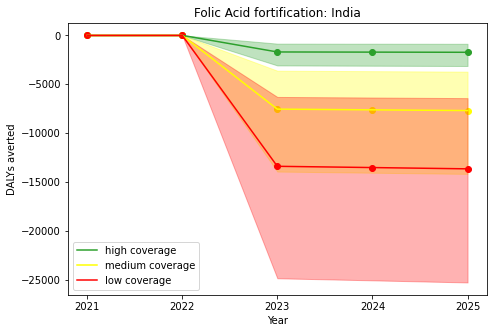

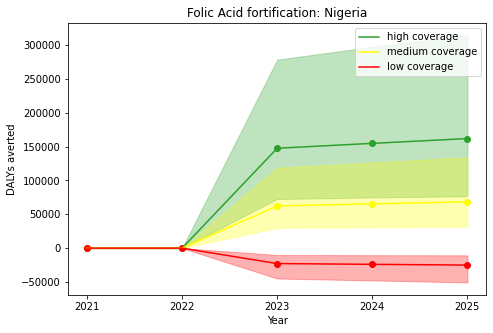

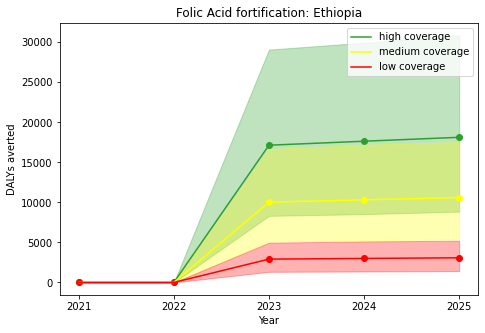

In [171]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


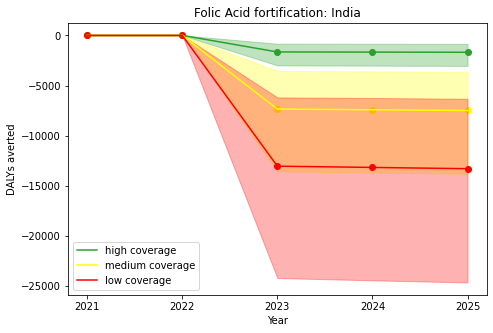

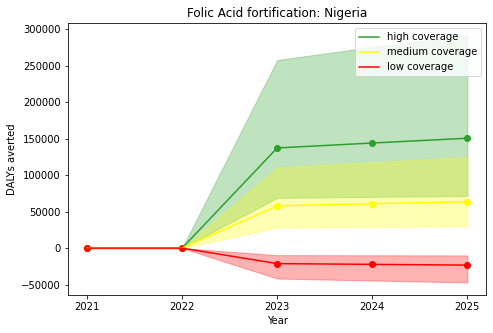

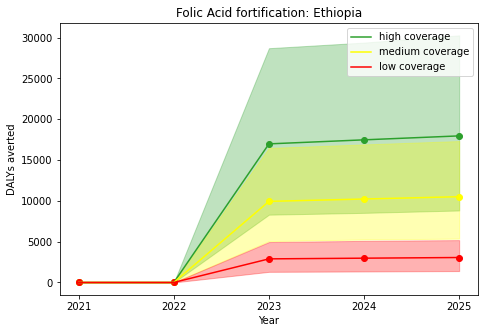

In [49]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


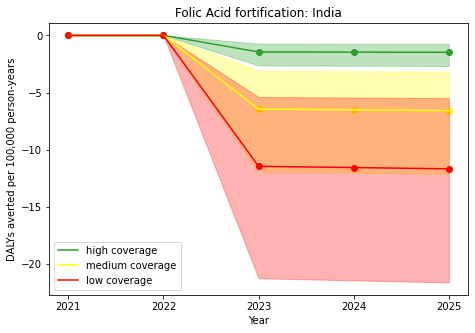

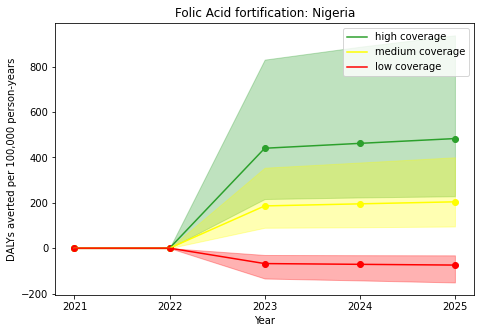

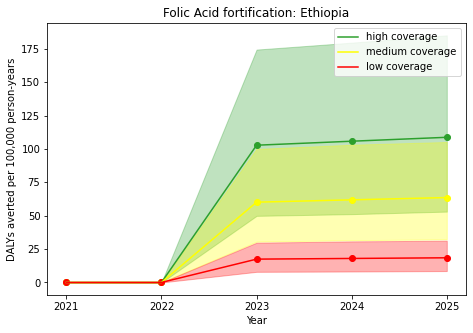

In [172]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


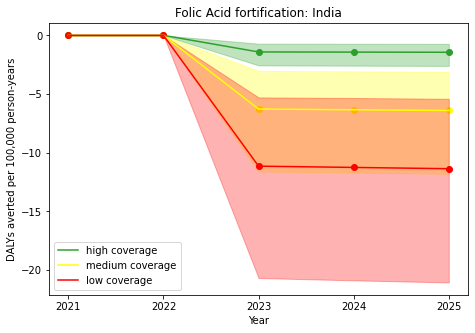

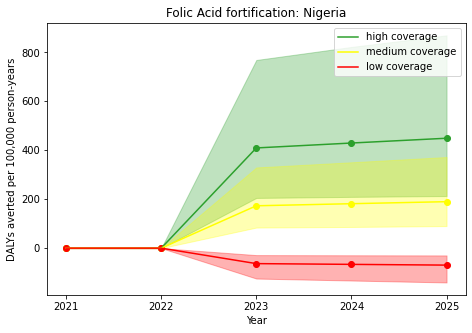

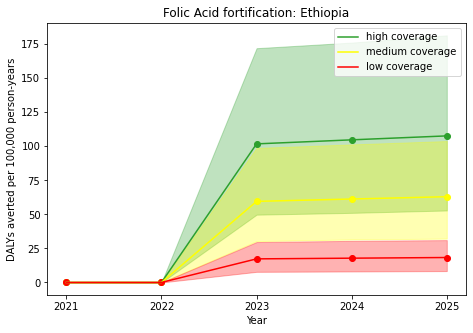

In [50]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


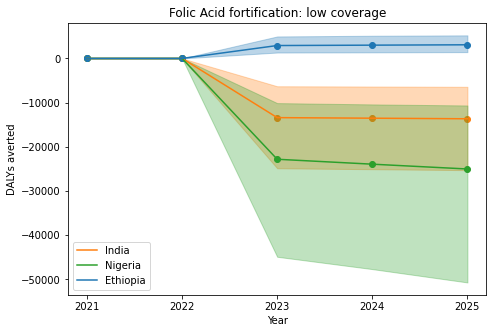

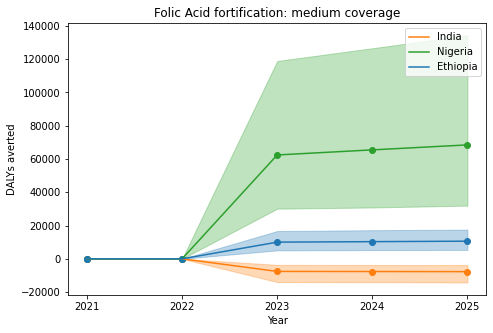

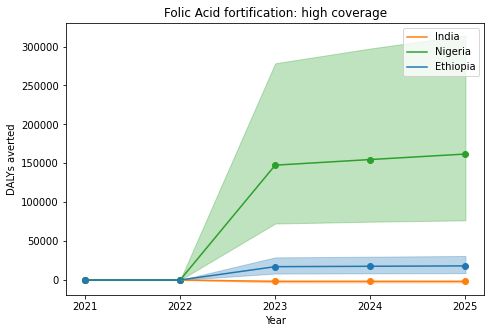

In [173]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


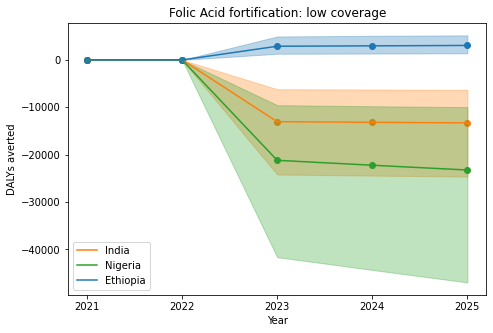

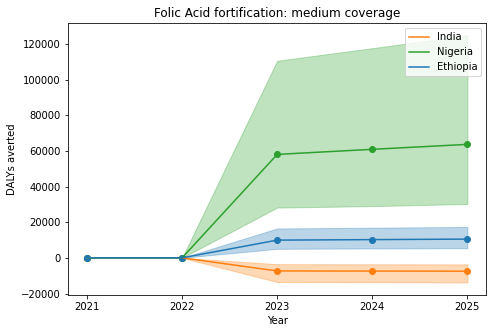

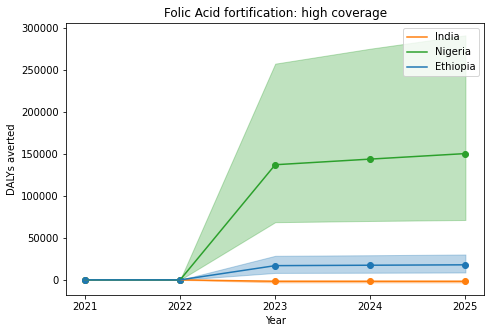

In [51]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


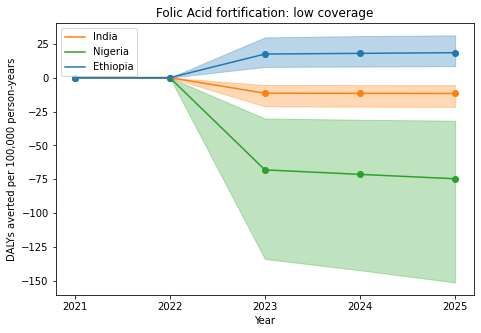

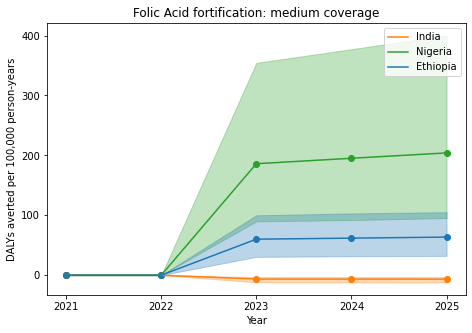

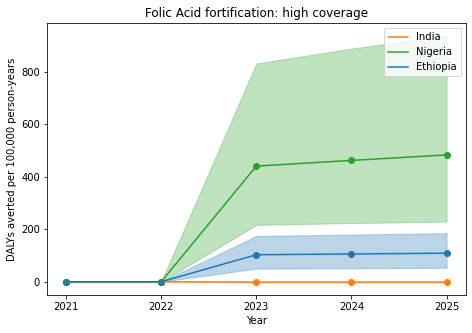

In [174]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
    #     for loc in [163]:

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)

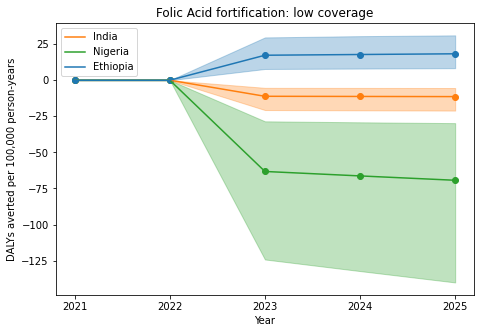

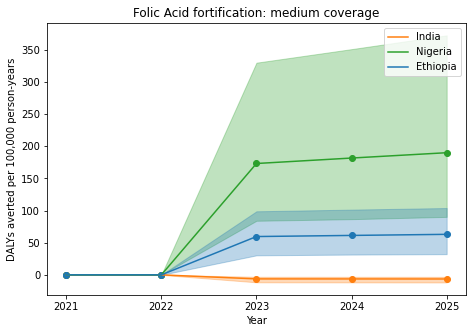

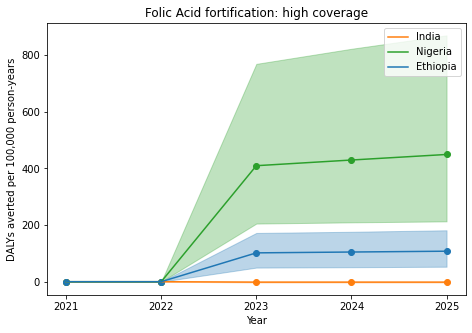

In [52]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
    #     for loc in [163]:

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)